In [1]:
import getpass
import os
from dotenv import load_dotenv

dotenv_path = os.path.join(os.getcwd(), '.env')
load_dotenv(dotenv_path)

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.types import Command

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

class State(TypedDict):
    messages: Annotated[list, add_messages]

chatbot_instructions = """
You are a routing assistant for a stock market chatbot. Your job is to analyze the user’s message and route it to one or more appropriate expert agents. Choose from the following five options:

- premarket: for questions about recent news or market trends.
- intraday: for questions about active or ongoing trades.
- postmarket: for reviewing trades or performance after the trading day.
- strategy: for proposed or hypothetical trading strategies.
- human_clarification: for questions that are not finance-related or require additional clarification

Instructions:

- Respond with one or more space-separated agent names. 
- Do not have duplicate names.
- If you include human_clarification, it must be the only agent selected. 
- If human_clarification is selected, include a follow-up question on the second line. If necessary, acknowledge what the user has said and gently remind the user that you're specifically designed as a trading assistant that can assist with premarket, intraday, postmarket, and strategy inquiries.
""".strip()

valid_experts = {"premarket", "intraday", "postmarket", "strategy"}

def chatbot(state: State):
    print("---------Chatbot---------")
    prompt = [SystemMessage(chatbot_instructions)] + state["messages"]
    ans = llm.invoke(prompt).content
    print(ans)
    if "human_clarification" in ans:
        return Command(
            update={"messages": [ans.splitline()[1]]},
            goto="human_clarification",
        )
    else:
        expert_names = ans.strip().split()
        while(not all(expert in valid_experts for expert in expert_names) 
              or len(expert_names) > len(set(expert_names))):
            ans = llm.invoke(prompt).content
        print(expert_names)
        return Command(
            goto=expert_names
        )


def human_clarification(state: State):
    print("---------Human Clarification---------")
    return 
    
def premarket(state: State):
    print("---------Premarket---------")
    return {"messages": [llm.invoke(state["messages"])]}

def intraday(state: State):
    print("---------Intraday---------")
    return {"messages": [llm.invoke(state["messages"])]}

def postmarket(state: State):
    print("---------Postmarket---------")
    return {"messages": [llm.invoke(state["messages"])]}

def strategy(state: State):
    print("---------Strategy---------")
    return {"messages": [llm.invoke(state["messages"])]}

def summary(state: State):
    print("---------Summary---------")
    return

def gating_mechanism(state: State):
    return ["premarket", "intraday", "postmarket"]

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("human_clarification", human_clarification)
graph_builder.add_node("premarket", premarket)
graph_builder.add_node("intraday", intraday)
graph_builder.add_node("postmarket", postmarket)
graph_builder.add_node("strategy", strategy)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("human_clarification", "chatbot")
# graph_builder.add_conditional_edges("chatbot", gating_mechanism, ["human_clarification", "premarket", "intraday", "postmarket", "strategy"])
graph_builder.add_node("summary", summary)
graph_builder.add_edge("premarket", "summary")
graph_builder.add_edge("intraday", "summary")
graph_builder.add_edge("postmarket", "summary")
graph_builder.add_edge("strategy", "summary")
graph_builder.add_edge("summary", END)

checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer, interrupt_before=["human_clarification"])

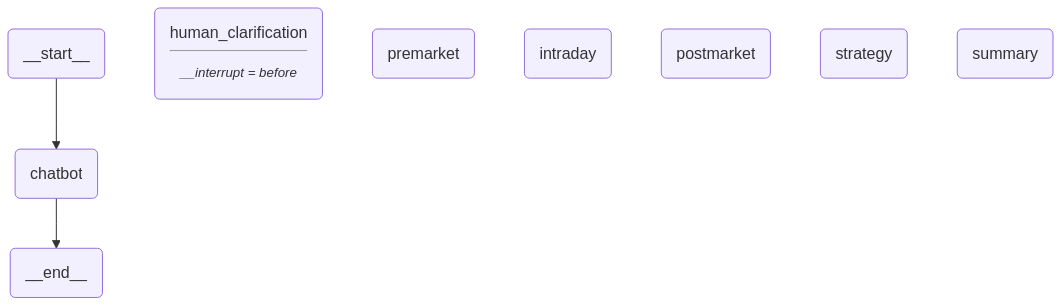

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [4]:
thread_config = {"configurable": {"thread_id": "paldemo"}}
for event in graph.stream({"messages": [HumanMessage("I have a strategy where I buy when price decreases")]}, config=thread_config, stream_mode="values"):
    # print(event)
    # for message in event['messages']:
    #    print(message)
    # print(event['messages'])
    print(event['messages'][-1])

print(graph.get_state(thread_config).next)
# history = list(graph.get_state_history(thread_config))
# print("---------History---------")
# print(history)
# graph.invoke({"messages": [HumanMessage("How are you today?")]})

content='I have a strategy where I buy when price decreases' additional_kwargs={} response_metadata={} id='5920779c-8b45-435d-a0e6-bd349f65b811'
---------Chatbot---------
strategy
['strategy']
---------Strategy---------
content='Your strategy of buying when the price decreases is a form of value investing or contrarian investing. This approach relies on the belief that:\n\n1. **Market Psychology**: Price decreases can indicate that an asset is undervalued, especially if the underlying fundamentals are still strong. Many investors may panic and sell during downturns, leading to opportunities to buy at a lower price.\n\n2. **Mean Reversion**: Prices often return to their historical averages, so buying during a dip may offer a better chance of capitalizing on future price increases.\n\n3. **Long-term Gains**: If you hold onto investments for the long term, buying during downturns may provide significant rewards when the market recovers.\n\nHowever, there are some considerations and risks 

In [5]:
for event in graph.stream(
    Command(resume="I'm good!"),
    config=thread_config,
    stream_mode="values",
):
    print(len(event['messages']))
    for message in event['messages']:
        print(message)

2
content='I have a strategy where I buy when price decreases' additional_kwargs={} response_metadata={} id='5920779c-8b45-435d-a0e6-bd349f65b811'
content='Your strategy of buying when the price decreases is a form of value investing or contrarian investing. This approach relies on the belief that:\n\n1. **Market Psychology**: Price decreases can indicate that an asset is undervalued, especially if the underlying fundamentals are still strong. Many investors may panic and sell during downturns, leading to opportunities to buy at a lower price.\n\n2. **Mean Reversion**: Prices often return to their historical averages, so buying during a dip may offer a better chance of capitalizing on future price increases.\n\n3. **Long-term Gains**: If you hold onto investments for the long term, buying during downturns may provide significant rewards when the market recovers.\n\nHowever, there are some considerations and risks associated with this strategy:\n\n1. **Identify the Cause**: Understand w